In [11]:
import numpy as np
import cv2
import glob
from skimage.transform import resize
from IPython.display import clear_output
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial import distance as ssd
from skimage import img_as_ubyte
from matplotlib.colors import ListedColormap

num_classes = 14

In [120]:

segcolor = np.array([(0, 0, 255), (0, 255, 0), (255, 0, 0),  (0, 255, 255), (255, 255, 0), (255, 0, 255),
       (0, 0, 192), (0, 192, 0), (192, 0, 0),  (0, 192, 128), (192, 192, 0), (192, 0, 192),
        (0, 0, 128), (0, 128, 0), (128, 0, 0),  (0, 128, 128), (128, 128, 0), (128, 0, 128),
       (0, 0, 64), (0, 64, 0), (64, 0, 0),  (0, 64, 64), (64, 64, 0), (64, 0, 64),
       (0, 0, 32), (0, 32, 0), (32, 0, 0),  (0, 32, 32), (32, 32, 0), (32, 0, 32),])

def extend_canvas(ori, symmetry = False):

    h, w = ori.shape[:2]
    img = np.ones((h+50, w+50, 3), dtype='uint8') * 255
    img[25:h+25,25:w+25,: ] = ori
    
    h, w = img.shape[:2]
    
    if symmetry == True:
        img[h//2:, w//2:, :] = img[:h//2, :w//2, :][::-1,::-1,:]
        img[h//2:, :w//2, :] = img[:h//2, :w//2, :][::-1,:,:]
        img[:h//2, w//2:, :] = img[:h//2, :w//2, :][:,::-1,:]

    return img

def get_edge(img):
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(255 - gimg,50,255,cv2.THRESH_BINARY)
    edge_image = np.stack((255-th,)*3, axis = -1)
    
    return edge_image

def get_mask(img):

    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(255 - gimg,50,255,cv2.THRESH_BINARY)

    contours, _ = cv2.findContours( th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.ones_like(th) * 255
    cv2.drawContours(mask, contours, -1, 0, -1)
    
    return mask

def get_masked_area(img, mask):
    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, th = cv2.threshold(255 - gimg,50,255,cv2.THRESH_BINARY)

    masked = cv2.bitwise_and(255-th, 255-th, mask=255-mask)
    
    return masked

def extract_used_colors(current_quant, mask):
    used_colors, used_colors_cnts = np.unique( (current_quant- mask.reshape(current_quant.shape[0], current_quant.shape[0],1)).reshape(-1,3), return_counts=True, axis=0)
    #used_colors_cnts = used_colors_cnts[ ~(used_colors==(0,0,0)).all(axis=-1)]
    #used_colors = used_colors[ ~(used_colors==(0,0,0)).all(axis=-1)]
    return used_colors, used_colors_cnts
    

def get_partitions(img, masked ):
    _, labels, stats, centroids = cv2.connectedComponentsWithStats(masked, connectivity=4)

    gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    imgh, imgw = img.shape[0], img.shape[0]
    area_crop = []
    coord = []
    prop_labels = []
    unique, counts = np.unique(labels, return_counts=True)

    for i in unique:

        tmp = np.zeros_like(gimg)
        tmp[labels == i] = 255

        x,y,w,h = cv2.boundingRect(tmp)
        if np.sum(labels == i) < 30 or w < 2 or h <2 or y < 2 or x < 2 or y+h > imgh -2 or x +w > imgw-2:
            continue
        area_crop.append(tmp[y:y+h, x:x+w])
        prop_labels.append(i)
        coord.append( np.sqrt( ( (y + h/2)/imgh - 0.5 )**2 + ( (x + w/2)/imgw - 0.5)**2 ) ) 

    return labels, prop_labels, area_crop, coord

def quantization(current, edge_image, mask, labels, prop_labels):
    
    coloring = edge_image.copy()

    used_colors = [] 
    for l in prop_labels:

        area = current[labels==l]
        uqe = np.unique(current[labels==l]//25, axis=0, return_counts=True)
        if (np.sum(labels==l) > 100 or np.mean(np.std( area, axis=-1)) > 50 ) and np.sum( uqe[1][(uqe[0]==(10,10,10)).all(axis=-1)] )/np.sum(uqe[1]) < 0.3:
            coloring[labels==l] = area
            c = np.mean(area[ ~(area == (255,255,255) ).all(axis=-1)], axis=0).astype(np.uint8)
            coloring[labels==l] = c
            used_colors += [c]

    used_colors_hsv = cv2.cvtColor( np.expand_dims(used_colors, axis=0), cv2.COLOR_BGR2HSV)[0]
    coloring_hsv = cv2.cvtColor( coloring, cv2.COLOR_BGR2HSV)

    clt = KMeans(n_clusters = 1)
    clt.fit(used_colors)
    baseline = clt.inertia_

    cluster = []
    center = []
    for i in range(2, 12):
        clt = KMeans(n_clusters = i)
        clt.fit(used_colors_hsv)
        cluster = clt.predict(used_colors_hsv)
        center = clt.cluster_centers_.astype(np.int32)

        if (baseline - clt.inertia_)/baseline < 0.1:
            break

        baseline = clt.inertia_

    for i, c in enumerate(used_colors_hsv):
        coloring_hsv[ (coloring_hsv==c).all(axis=-1) ] = center[cluster[i]]

    coloring = cv2.cvtColor( coloring_hsv, cv2.COLOR_HSV2BGR)
            
    return coloring

def fill_current_image(current, labels, prop_labels, sim_mat):
    
    out = current.copy()
    for i, l in enumerate(prop_labels):

        c = np.median(current[labels==l], axis=0)

        area = current[labels==l]
        uqe = np.unique(current[labels==l]//25, axis=0, return_counts=True)
        
        # 색칠되어 있으면 ...
        if np.sum( uqe[1][(uqe[0]==(10,10,10)).all(axis=-1)] )/np.sum(uqe[1]) < 0.1:
            
            idx = [ k for k in np.argsort(sim_mat[i]) if sim_mat[i][k] < 0.01]

            # 이거랑 비슷한 곳들을 칠함 
            for j in idx:
                c2 = np.median(current[labels==prop_labels[j]], axis=0)

                # 이거랑 비슷한 곳들이 하얀색일 때 칠함 
                ### current는 하얀색인데.. out은 이미 색칠이 된 경우 따로 Dictionary로 빼면 될듯 {j : [color1, color2, ...] }
                ### 나중에 이 Dictionary 를 가지고 out에서 
                ### 어떤 조각의 color1 영역만 추출하고 추출된 영역을 모양이 좌우 대칭 되도록 회전하고 
                ### 대칭된 모양에 원래 색을 입혀서 좌우 차이를 계산
                ### Dictionary 상 해당 조각의 다른 색상으로 바꿔보고 좌우 차이 계산 
                ### 좌우 차이가 최소인 색상으로 선택 

                if (c2==(255,255,255)).all(axis=-1):
                    out[labels==prop_labels[j]] = c

    return out
    
def color_partitions(labels, prop_labels, area_crop, coord, edge_image, current = None):

    if current is None:
        current = edge_image.copy()
        
    num_areas = len(area_crop)
    sim_mat=np.zeros((num_areas, num_areas))

    cluster=np.zeros(num_areas, dtype=int)
    
    label_mean = np.array([ current[labels==i].mean(0) for i in prop_labels ])

    for i in range(0,num_areas):
        for j in range(0, num_areas):
            
            if i >= j :
                continue
            elif ( label_mean[i] == (255,255,255)).all(axis=-1) or \
                ( label_mean[j] == (255,255,255)).all(axis=-1):
                im1=np.array(area_crop[i])
                im2=np.array(area_crop[j])
                sim_mat[i][j]= cv2.matchShapes(im1,im2,cv2.CONTOURS_MATCH_I2,0) + 0.5 * abs(coord[i] - coord[j])
            elif (label_mean[i] == label_mean[j]).all(axis=-1):
                sim_mat[i][j]=  0.01
            else:
                sim_mat[i][j]=  1000

            sim_mat[j][i]= sim_mat[i][j] 
    '''
     Cluster the contours using similarity matrix and max cluster no.
     Returns cluster vector  [Range: 0 - (num_classes-1)]
    '''
    Zd = linkage(ssd.squareform(sim_mat), method="complete") 
    cluster = fcluster(Zd, num_classes, criterion='maxclust') - 1 

    cids, cluster_cnt = np.unique(cluster, return_counts=True, axis = 0)

    seg_color_idx = []
    out = np.ones_like(edge_image) * 255
    for i, c in enumerate(cluster):
        out[labels==prop_labels[i]] = segcolor[c]
        seg_color_idx += [c]
    seg_color_idx = np.unique(seg_color_idx)
        
    out[np.where( (edge_image==(0,0,0)).all(axis=-1))] = (0,0,0)   
    
    used_colors = np.unique(current.reshape((-1, 3)), axis = 0)
    used_colors = used_colors[ ~( (used_colors==(255,255,255)).all(axis=-1) ) ]
    unused_color_idx = [s for s in range(len(segcolor)) if s not in seg_color_idx]

    for c in used_colors:

        target_area_c = np.median(out[ (current==c).all(axis=-1) ] .reshape((-1, 3)), axis = 0)

        if ~((target_area_c == c).all(axis=-1)):
            target_area_idx = (out==target_area_c).all(axis=-1)
            replace_color_idx = (out==c).all(axis=-1)

            out[replace_color_idx] = target_area_c
            out[target_area_idx] = c
    
    return out, sim_mat



# 1. 스케치 > 완성

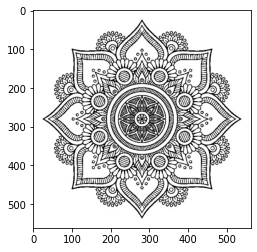

In [121]:
img = cv2.imread('test.jpg')

ext_img = extend_canvas(img, symmetry = True)
plt.imshow(ext_img)

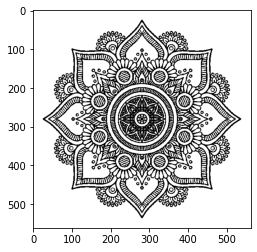

In [122]:
edge_image = get_edge(ext_img)
plt.imshow(edge_image, cmap='gray')

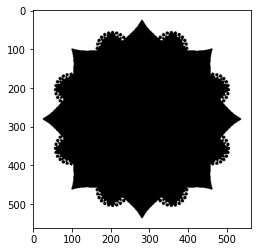

In [123]:
mask = get_mask(edge_image)
plt.imshow(mask, cmap='gray')

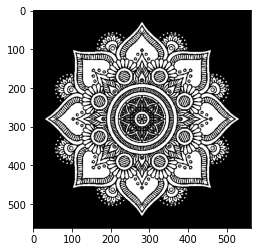

In [124]:
masked = get_masked_area(edge_image, mask)
plt.imshow(masked, cmap='gray')

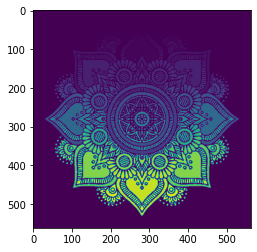

In [125]:
labels, prop_labels, area_crop, coord = get_partitions(edge_image, masked)
plt.imshow(labels,)

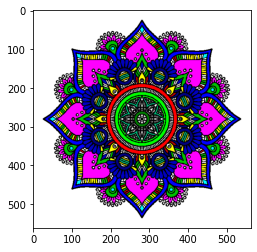

In [126]:
final_output, sim_mat = color_partitions(labels, prop_labels, area_crop, coord, edge_image)
plt.imshow(final_output)

# 2. 색칠 중 이미지 > 완성

### (2.0 색칠 중 이미지 만들기)

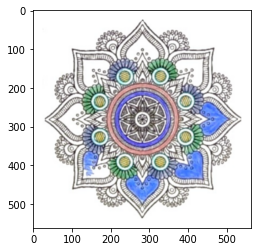

In [127]:
current2 = cv2.imread('coloring.jpg')

current2 = img_as_ubyte(resize(current2, (512,512)))[:,:,:3]
current2 = extend_canvas(current2)
plt.imshow(current2)

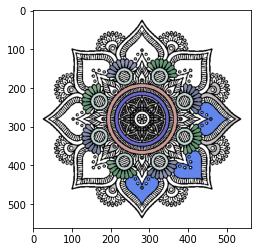

In [128]:
coloring = quantization(current2, edge_image, mask, labels, prop_labels)
plt.imshow(coloring)

In [129]:
used_colors, used_colors_cnts = extract_used_colors(coloring, mask)
used_colors, used_colors_cnts

(array([[  0,   0,   0],
        [ 98, 134, 236],
        [103, 153, 121],
        [108, 105, 208],
        [118, 127, 159],
        [131, 170, 142],
        [143, 148, 175],
        [166, 160, 168],
        [183, 178, 212],
        [193, 216, 211],
        [197, 194, 193],
        [204, 154, 151],
        [255, 255, 255]], dtype=uint8),
 array([221464,   9032,   3299,   2964,   2286,   1261,   2274,    331,
           549,   5228,   4403,   4224,  58529]))

### 2.2 현재까지 색칠한 패턴에 맞춰 채우기

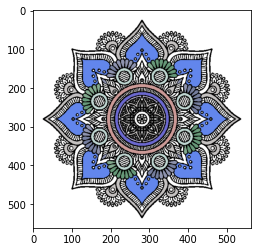

In [130]:
current_filled = fill_current_image(coloring, labels, prop_labels, sim_mat)
plt.imshow(current_filled)

### 2.3 비어있는 부분 채우기

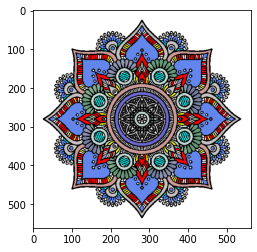

In [131]:
final_output2, _ = color_partitions(labels, prop_labels, area_crop, coord, edge_image, current_filled)
plt.imshow(final_output2)